In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import r2_score, silhouette_score
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Set seaborn theme
sns.set()

In [2]:
# Read Data (Input: CSV File with 2 Columns seperated by ','; Output: Nx2 DataFrame)
data = pd.read_csv(filepath_or_buffer = "C:\\Users\\negrini\Desktop\\time_series_user.csv", sep = ",", index_col=False, header=0)

# Only if different export setting in azure:
# data.drop("time", axis=1, inplace = True)

In [3]:
# Descriptive Statistic before Outlier Removal (Comparison see below)
data_stats1 = data.describe()

In [4]:
# Create numpy Array, take date as indexes
X_uncleaned = np.arange(0, data.shape[0], 1).reshape(-1, 1)
Y_uncleaned = data.iloc[:, 1].values.reshape(-1, 1)

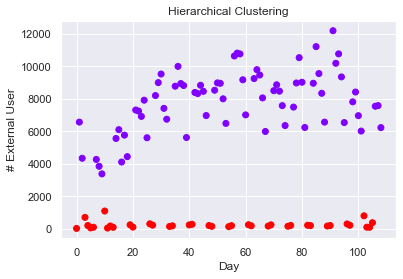

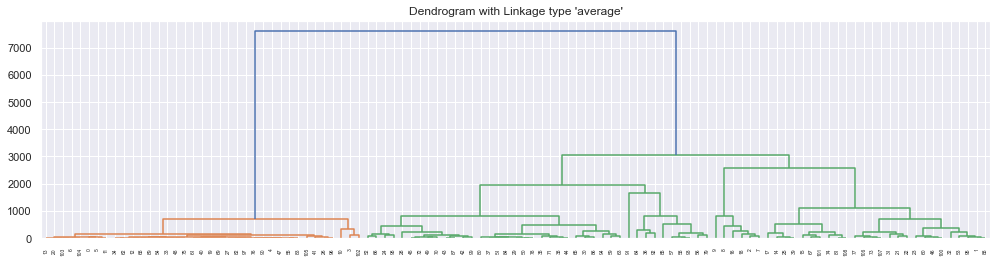

In [6]:
# Hierarchical Clustering + Plot
cluster = AgglomerativeClustering(n_clusters=2, linkage="average")
cluster.fit(Y_uncleaned)
plt.scatter(X_uncleaned, Y_uncleaned, c=cluster.labels_, cmap="rainbow")
plt.title("Hierarchical Clustering")
plt.xlabel("Day")
plt.ylabel("# External User")
plt.savefig("clustering.png", dpi=200)
plt.show()

# Plot Dendrogram
fig, axs = plt.subplots(figsize=(17, 4))
# Merge X and Y and reshape to Nx2 Matrix
#data_vector = np.array((X_uncleaned, Y_uncleaned)).T.reshape((-1,2))
link = linkage(Y_uncleaned, method="average")
dendrogram(link, orientation="top") # Change Orientation to "right" for horizontal plotting
plt.title("Dendrogram with Linkage type 'average'")
fig.savefig("dendrogram.png", dpi=200)
#print("Type(date_vector) = {}; \t Shape(data_vector) = {};".format(type(data_vector), data_vector.shape))

In [7]:
# Append Dataframe with new Column called "Outlier" which entries are the cluster label
data['Outlier'] = pd.Series(cluster.labels_, index=data.index)
print(data)

                  Datum [UTC]     x  Outlier
0    21.12.2020, 00:00:00.000    27        1
1    22.12.2020, 00:00:00.000  6564        0
2    23.12.2020, 00:00:00.000  4341        0
3    24.12.2020, 00:00:00.000   706        1
4    25.12.2020, 00:00:00.000   204        1
..                        ...   ...      ...
104    4.4.2021, 00:00:00.000    99        1
105    5.4.2021, 00:00:00.000   379        1
106    6.4.2021, 00:00:00.000  7538        0
107    7.4.2021, 00:00:00.000  7578        0
108    8.4.2021, 00:00:00.000  6225        0

[109 rows x 3 columns]


In [8]:
# Remove Outlier
data = data[data.Outlier != 1]
# "Refresh" Index
data = data.reset_index(drop=True)

In [9]:
# Create numpy Array, take date as indexes
X = np.arange(0, data.shape[0], 1).reshape(-1, 1)
Y = data.iloc[:, 1].values.reshape(-1, 1)

In [10]:
# Create Model and fit data
model = linear_model.LinearRegression()
model.fit(X, Y)
Y_pred = model.predict(X)

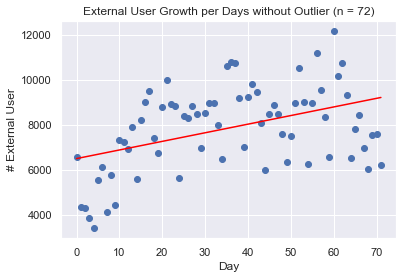

R2 Score: 0.18
Slope: 38.31
Interzept: 6490.0746
Average Daily User growth: 38
Predicted next Day User Count: 9227 = 38 * 73 + 6490


In [11]:
# Plot Settings
plt.scatter(X, Y)
plt.plot(Y_pred, color = "red")
plt.xlabel("Day")
plt.ylabel("# External User")
plt.title("External User Growth per Days without Outlier (n = {})".format(X.size))
plt.savefig("regression.png", dpi=200)
plt.show()

# Scores
r2score = r2_score(Y, Y_pred)
print("R2 Score: %.2f" %r2score)
print("Slope: %.2f" %model.coef_)
print("Interzept: %.4f" %model.intercept_)

# General Info
slope = model.coef_.astype(int)[0][0]
predict_User = slope * X.size+1 + model.intercept_
print("Average Daily User growth: {}".format(slope)) 
print("Predicted next Day User Count: {} = {} * {} + {}".format(int(predict_User), slope, X.size+1, model.intercept_[0].astype(int)))

In [15]:
# Descriptive Statistics after Outlier Removal
data_stats2 = data.describe()
diff_stats =  data_stats2.subtract(data_stats1)
stats = pd.concat([data_stats1, data_stats2, diff_stats], axis=1)                           # Create new df with concatination
stats.drop("Outlier", axis=1, inplace = True)                                               # Drop Outlier Column
stats.columns = ["Stats with Outlier", "Stats after Outlier Removal", "Difference"]         # Rename Columns
print(stats)

       Stats with Outlier  Stats after Outlier Removal   Difference
count          109.000000                    72.000000   -37.000000
mean          5266.954128                  7850.236111  2583.281983
std           3929.028431                  1877.163049 -2051.865382
min             27.000000                  3381.000000  3354.000000
25%            247.000000                  6556.000000  6309.000000
50%           6535.000000                  8124.500000  1589.500000
75%           8522.000000                  8979.000000   457.000000
max          12181.000000                 12181.000000     0.000000


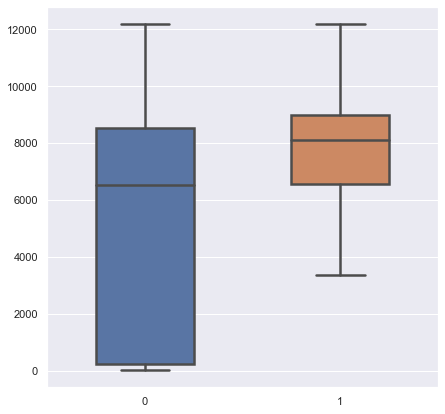

In [16]:
# Plot Boxplot of Y_uncleaned and Y (without Outlier, with Outlier)
fig, axs = plt.subplots(figsize=(7, 7))
axs = sns.boxplot(data = [Y_uncleaned, Y], orient="v", width=0.5, linewidth=2.5)
fig.savefig("boxplot.png", dpi=200)